<a href="https://colab.research.google.com/github/nrajmalwar/EVA-6-Phase-1/blob/main/Session_05/Model_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target

1. Build the model with right setup of transforms, dataloader, training and testing functions and loops.
2. Build the skeleton of the model with less than 10,000 parameters following output size and receptive field calculations.
3. Place the MaxPooling (RF = 5) and GlobalAveragePooling (last but one layer) at appropriate positions
4. Print the misclassified images to analyse.

# Result
1. Parameters - 9,264
2. Best Train Acc - 98.82%
3. Best Test Acc - 98.76%

# Analysis
1. Model is light and very slightly overfitting.
2. Model has potential to attain more train accuracy and in turn higher test accuracy.
3. Train accuracy is not increasing in a stable and gradual manner.
4. We can expect model stabilization through regularization and an increase in accuracy with BatchNormalization.
5. Misclassifed images shows that model makes basic mistakes between pairs (4,9), (5,2), (8,9). We will look to improve on this later. The general classification seems to be good for a skeleton model.


# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
!pip install torchsummary
from torchsummary import summary

# Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


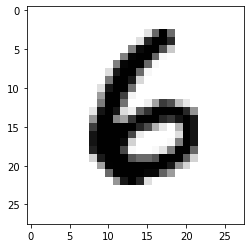

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

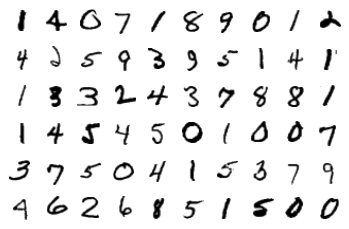

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # INPUT BLOCK
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) 
          # output_size = 12, RF = 6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 10, RF = 10
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 8, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 6, RF = 18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 4, RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1, RF = 28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # No activation in last layer
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Parameters

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
            Conv2d-3           [-1, 14, 24, 24]           1,512
              ReLU-4           [-1, 14, 24, 24]               0
         MaxPool2d-5           [-1, 14, 12, 12]               0
            Conv2d-6           [-1, 10, 12, 12]             140
            Conv2d-7           [-1, 14, 10, 10]           1,260
              ReLU-8           [-1, 14, 10, 10]               0
            Conv2d-9             [-1, 14, 8, 8]           1,764
             ReLU-10             [-1, 14, 8, 8]               0
           Conv2d-11             [-1, 16, 6, 6]           2,016
             ReLU-12             [-1, 16, 6, 6]               0
           Conv2d-13             [-1, 16, 4, 4]           2,304
             ReLU-14             [

# Training and Testing Functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Model Training and Testing

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=2.2922985553741455 Batch_id=468 Accuracy=10.87: 100%|██████████| 469/469 [00:10<00:00, 45.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2913, Accuracy: 974/10000 (9.74%)

EPOCH: 1


Loss=0.2550502121448517 Batch_id=468 Accuracy=73.17: 100%|██████████| 469/469 [00:10<00:00, 45.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1914, Accuracy: 9448/10000 (94.48%)

EPOCH: 2


Loss=0.04704311490058899 Batch_id=468 Accuracy=95.15: 100%|██████████| 469/469 [00:10<00:00, 45.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1097, Accuracy: 9655/10000 (96.55%)

EPOCH: 3


Loss=0.04905228316783905 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9693/10000 (96.93%)

EPOCH: 4


Loss=0.09154229611158371 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:10<00:00, 45.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9769/10000 (97.69%)

EPOCH: 5


Loss=0.02281184494495392 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:10<00:00, 44.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9790/10000 (97.90%)

EPOCH: 6


Loss=0.0482543520629406 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:10<00:00, 45.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9836/10000 (98.36%)

EPOCH: 7


Loss=0.033529337495565414 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9828/10000 (98.28%)

EPOCH: 8


Loss=0.021639583632349968 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9852/10000 (98.52%)

EPOCH: 9


Loss=0.05984175205230713 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:11<00:00, 41.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9842/10000 (98.42%)

EPOCH: 10


Loss=0.012136424891650677 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9842/10000 (98.42%)

EPOCH: 11


Loss=0.05423974618315697 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:10<00:00, 44.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9853/10000 (98.53%)

EPOCH: 12


Loss=0.021416841074824333 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 43.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9864/10000 (98.64%)

EPOCH: 13


Loss=0.0342087484896183 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Loss=0.024919897317886353 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]



Test set: Average loss: 0.0427, Accuracy: 9874/10000 (98.74%)



# Accuracy and Loss Graphs

Text(0.5, 1.0, 'Test Accuracy')

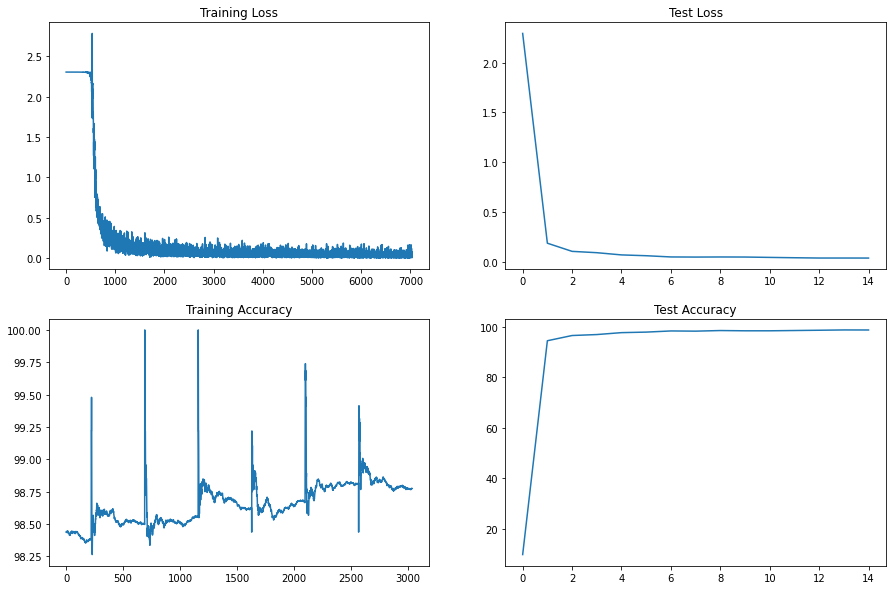

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


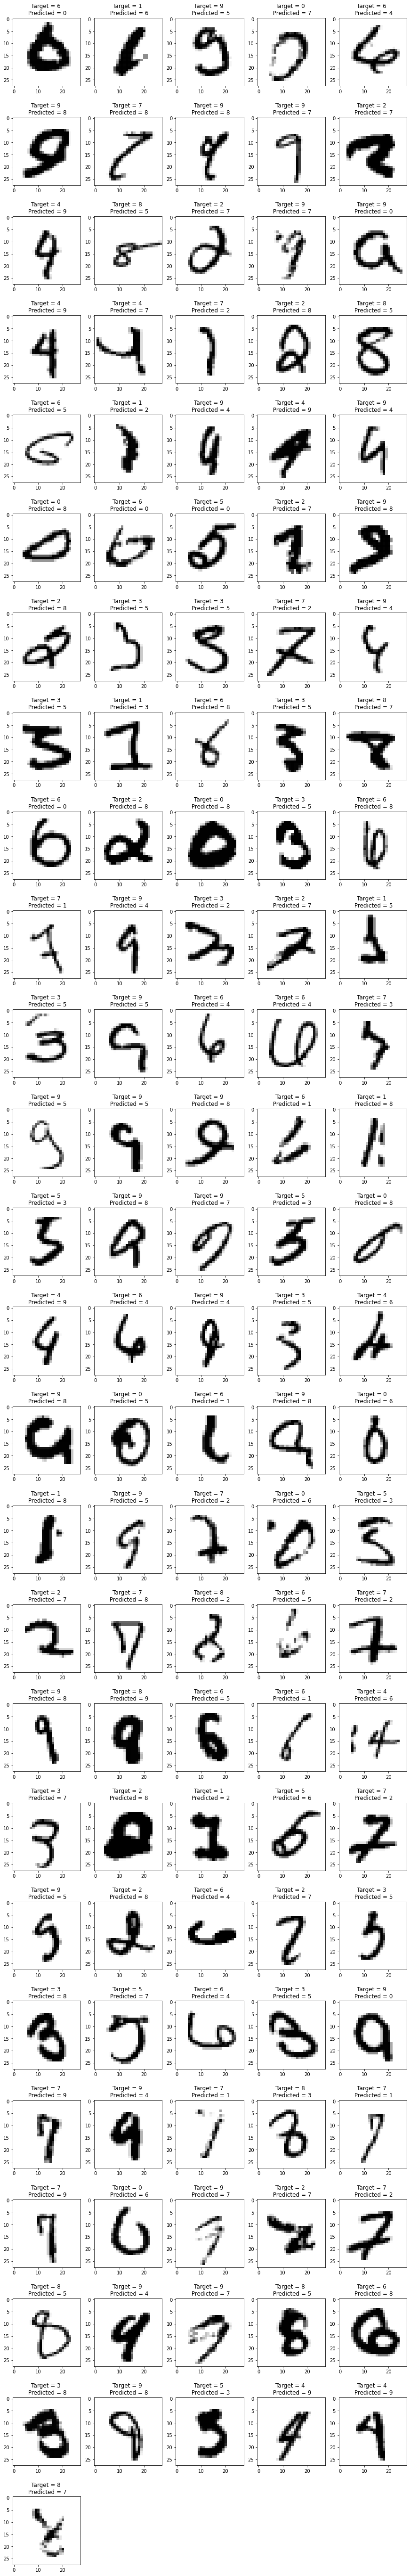

In [15]:
model.eval()

# Create a test loader with batch size equal to test data length
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        # Get the indexes of images that are incorrectly classified
        indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

        # Plot the misclassified images
        fig = plt.figure(figsize=(15, 100))
        rows = np.ceil(len(indexes)/5)
        for i, idx in enumerate(indexes):
            ax = fig.add_subplot(rows, 5, i+1)
            ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
            ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
        
        plt.show()